## Bigram model using count table

In [1]:
import torch

words = open('names.txt', 'r').read().splitlines()

# create bigram count table
N = torch.zeros((27, 27))

# create stoi and itos
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

# fill in count table
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1, ix2] += 1

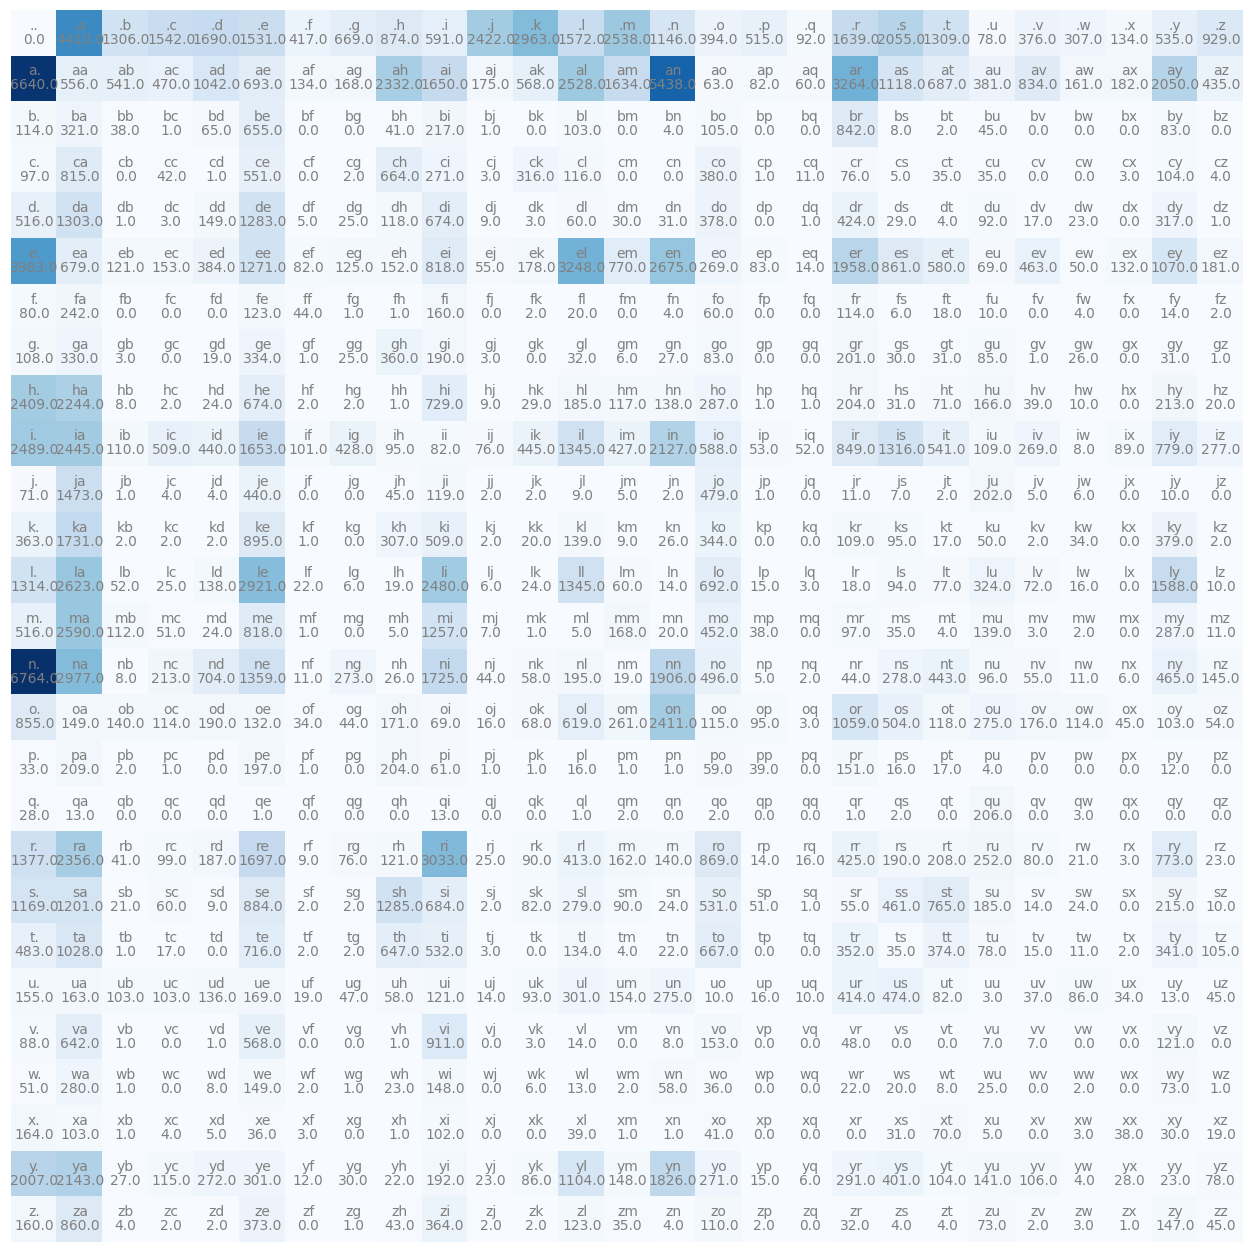

In [2]:
# visualize count table
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [3]:
# sample names with count table
g = torch.Generator().manual_seed(4832878)

# normalize count table
P = (N+1).float()
P /= P.sum(1, keepdims=True)

# sample
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

ritmotosaherelenueitterh.
cay.
yilan.
lisahelenon.
arerikaragriya.


In [4]:
# calculate quality of model with negative log likelihood
log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        
# mean of negative log likelihood
nll = -log_likelihood / n
print(nll.item())

2.454400062561035


## Bigram model using neural network

In [5]:
# create traning set (x, y)
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        
# don't forget the difference between .tensor() and .Tensor()!
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

g = torch.Generator().manual_seed(4832878)

# 27 neurons with 27 inputs
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [7]:
import torch.nn.functional as F

# gradient descent
for k in range(10):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # one-hot encoding
    logits = xenc @ W # predict log-counts; it's immitating the count table
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # these two lines are softmax
    loss = -probs[torch.arange(ys.nelement()), ys].log().mean() + 0.01*(W**2).mean() # loss + regularization (similar to smoothing)
    print(loss.item())
    
    # backward pass
    W.grad = None # set gradient = 0
    loss.backward()

    # update
    W.data += -50 * W.grad

2.480433464050293
2.480433464050293
2.480433464050293
2.4804329872131348
2.480433225631714
2.4804327487945557
2.4804329872131348
2.4804327487945557
2.4804327487945557
2.4804325103759766


In [8]:
# sample names with nn
g = torch.Generator().manual_seed(4832878)

for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
          break
    print(''.join(out))

iltmytl.
.
herhldnunht.
mrhr.
ny.
